<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/branch_1/TVAE_corpus_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-datasets==1.2.0

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [4]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
# folder = '/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/'
folder = '/content/drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(folder, 'train_corpus_v2.csv')
path_to_corpus

'/content/drive/My Drive/Colab Notebooks/desafio final/train_corpus_v2.csv'

In [5]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [6]:
data.sample(10)

,Unnamed: 0.1,line,len,book,genre,category
49224,58155,sus vagos zaguanes donde empiezan escaleras cuyo final es imprevisible,70,Cartas_1955-1964_-_Julio_Cortazar,cortazar,Book
51326,60572,Esta mañana recibí una carta de @name .,39,Cartas_1955-1964_-_Julio_Cortazar,cortazar,Book
98499,113444,La mujer levantó la cabeza y también me sonrió .,48,Los-autonautas-de-la-cosmopista-Julio-Cortazar,cortazar,Book
18391,22938,e iba a decir en un papel la gracia,35,_como_fueron_-_Eloy_Sanchez_Rosillo,poesía,Book
134892,157654,aliena a los escritores más sensibles de su lengua materna,58,ogia_del_sofista_-_Fernando_Savater,filosofia,Book
85287,98590,—Pero alguna vez habrás hablado —dice contradictoriamente Pierre— .,67,Las-armas-secretas-Julio-Cortazar,cortazar,Book
14103,17225,"a estar casi vencida , junto a ti , haciendo corro , las mujeres",64,_como_fueron_-_Eloy_Sanchez_Rosillo,poesía,Book
16747,20675,"belleza que está cerca y sabe acompañar ,",41,_como_fueron_-_Eloy_Sanchez_Rosillo,poesía,Book
26688,32649,@name final nos sentamos sobre el pretil,40,on_y_otros_relatos_-_Julio_Cortazar,cortazar,Book
128807,150779,Tampoco aquí consiste ella en el deseo de infligir dolor a los demás .,70,l_miedo_a_la_libertad_-_Erich_Fromm,filosofia,Book


In [7]:
data.shape

(152124, 6)

In [8]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # vamos a crear espacios entre las frases y los puntos:
  # ej: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r'\d+', "{num}", sentence) 

  # reemplazamos por 'vacio' todo lo que no sea (a-z, A-Z, ".", "?", "!", ",")
  accentedCharacters = "áéíóúÁÉÍÓÚñÑäëïöüÜ"
  sentence = re.sub(r"[^a-zA-Z" + accentedCharacters + "@?.!,]+", " ", sentence)
  
  sentence = sentence.strip()
  return sentence

In [9]:
data.iloc[:,1] = data.iloc[:,1].apply(preprocess_sentence)

In [10]:
data.iloc[0:5,1]

0                                   obra del príncipe de la dulce @name
1                          más conocido por todos como txus di fellatio
2        y un disco de diamante por la venta de un millón de ejemplares
3    son el testimonio de la historia viva que está viviendo este grupo
4                     tanto en españa como en el continente americano .
Name: line, dtype: object

In [11]:
## tokenizador de subwords
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    data.iloc[:,1].tolist(), target_vocab_size=2**13)

### Preprocesamiento

In [12]:
VOCAB_SIZE = tokenizer.vocab_size

In [13]:
## el tokenizador tiene dos metodos: encode y decode:
print(tokenizer.encode("cantar"))
print(tokenizer.decode(tokenizer.encode("cantar")))

[3958]
cantar


In [14]:
sample_string = 'todo lo que nos desvela'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

assert original_string == sample_string

Tokenized string is [42, 17, 4, 47, 4681, 155]
The original string: todo lo que nos desvela
42 ----> todo 
17 ----> lo 
4 ----> que 
47 ----> nos 
4681 ----> desve
155 ----> la


In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 32

In [16]:
# Tokenizamos, filtramos las secuencias menores al largo maximo
# y las paddeamos 
def tokenize_and_filter(inputs):
  tokenized_inputs = {}
  count_dict = 0
  for index, line in inputs.iterrows():
    sentence = line['line']
    # tokenizamos + tokens especiales
    sentence = tokenizer.encode(sentence)
    # filtramos
    if len(sentence) <= MAX_LENGTH:
      # tokenized_inputs.append(sentence)
      tokenized_inputs[count_dict] = {"line": sentence, "len": len(sentence), "genre": line['genre'], "category": line['category']}
      count_dict += 1

  data_filtered = pd.DataFrame.from_dict(tokenized_inputs, "index")
  
  return data_filtered

data_tokens = tokenize_and_filter(data)

In [17]:
data_tokens

,line,len,genre,category
0,"[414, 24, 7786, 7954, 1, 5, 2997, 22, 32]",9,poesía,Book
1,"[30, 3316, 20, 96, 27, 8038, 8042, 1374, 1420, 545, 827, 294, 8033]",13,poesía,Book
2,"[6, 15, 4680, 7954, 1, 737, 3030, 7954, 20, 5, 6852, 7954, 1, 15, 4172, 93, 1, 3619, 55]",19,poesía,Book
3,"[79, 9, 6718, 7954, 1, 5, 666, 6710, 4, 70, 7292, 7954, 84, 1923, 575]",15,poesía,Book
4,"[158, 8, 3041, 7954, 27, 8, 9, 5369, 476, 4957, 3]",11,poesía,Book
...,...,...,...,...
137532,"[315, 6582, 3004, 2, 4594, 60, 29, 315, 6582, 3]",10,filosofia,Book
137533,"[21, 3402, 14, 1, 3296, 5758, 1479, 490, 120, 6, 9, 1307, 6475, 3]",14,filosofia,Book
137534,"[7986, 10, 4594, 60, 29, 1929, 3363, 531, 4723, 283, 3]",11,filosofia,Book
137535,"[7986, 10, 1861, 3225, 7954, 1, 4946, 8022, 6286, 7, 1313, 3471, 724, 1309, 3201, 14, 2353, 228,...",20,filosofia,Book


In [19]:
# paddeamos
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.line.tolist(), maxlen=MAX_LENGTH, padding='post')
  
data_lines[0]

array([ 414,   24, 7786, 7954,    1,    5, 2997,   22,   32,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [20]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8178
frases: 137537


In [21]:
# Tomamos la mayor cantidad de frases que sea multiplo de [BATCH_SIZE] para no generar problemas en el entrenamiento
FINAL_LINES = int(len(data_lines) / BATCH_SIZE) * BATCH_SIZE
FINAL_LINES

137536

In [22]:
# Adapto para que de un multiplo del batch size (64)
data_lines = data_lines[0:FINAL_LINES]
len(data_lines)

137536

In [23]:
# saco el token de start de los outputs
dataset = tf.data.Dataset.from_tensor_slices((data_lines,data_lines))

dataset = dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
#dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Elementos básicos

In [24]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculamos attention weights """

  ## hacemos el producto de query por la transpuesta de key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  ## escalamos por la raiz cuadrado del # dims
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  ## agregamos la mascara
  if mask is not None:
    logits += (mask * -1e9)

  ## aplicamos la softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  ## y multiplicamos por value 
  output = tf.matmul(attention_weights, value)

  return output

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

  ''' Vamos a armar la capa para multihead attention '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)

    ## que es este super?
    ## super() te permite acceeder a los metodos de la super clase de la cual
    ## la subclase está heredando. En este caso, estas herendando de Layers.
        
    ## definimos algunos parametros: cuantas cabezas va a tener self attention 
    ## y la dimensionalidad del embedding
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    ## cuantas dimensiones va a tener cada cabeza:
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    ## vamos a armar la division en cabezas. 
    ## se va a entender mejor en el siguiente bloque de codigo
    ## por ahora es solamente la forma en la que 
    ## reacomodamos los datos para armar las cabezas
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])


  def get_config(self):
          config = super().get_config().copy()
          config.update({
              'num_heads': self.num_heads,
              'd_model': self.d_model,
              'depth': self.depth,
              'query_dense': self.query_dense,
              'key_dense': self.key_dense,
              'value_dense': self.value_dense,
              'dense': self.dense             
          })
          return config

  def call(self, inputs):
    ''' Este call es el metodo que  va a llamar keras para usar la capa'''

    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # print(self.name, mask)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # acomodamos las dimensiones
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenamos las cabezas
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [27]:
## creamos una mascara para el padding (asi nos nos molesta)
## con esto lo que hacemos es despues pasarselo a la capa 
## anterior y eliminamos los paddings

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)

  return mask[:, tf.newaxis, tf.newaxis, :]

In [28]:
## vamos a crear la otra mascara:
## ahora queremos la mascara para no ver el futuro
## vamos a incorporarle tambien la mascara para el padding

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## aca la mascara para el padding
  padding_mask = create_padding_mask(x)

  return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
class PositionalEncoding(tf.keras.layers.Layer):
  ''' Armamos los encodings de posición '''

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  ## comparar con formula de la teorica
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

   
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # seno a los indices pares
    sines = tf.math.sin(angle_rads[:, 0::2])
    # coseno a los impares
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, :]
    return tf.cast(pos_encoding, tf.float32)

  def get_config(self):

          config = super().get_config().copy()
          config.update({
              'pos_encoding': self.pos_encoding
          })
          return config

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [30]:
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [31]:
## ya tenemos todos los ingredientes para armar una capa de encoder
## todavía no es el encoder entero!

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
## ahora si: el encoder
## vamos a definir una funcion que nos devuelva un modelo que tenga
## num_layers bloques de encoder:

def encoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, latent_space, name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  print('enc_inputs',inputs)

  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  ## partimos de los embeddings
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  ## y les sumamos el positional encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  ## y usamos tantos bloques como querramos
  for i in range(num_layers):
    outputs = encoder_layer(
                            units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i),
                        )([outputs, padding_mask])

  outputs  = tf.keras.layers.Reshape([MAX_LENGTH * d_model])(outputs)
  # Generamos la media
  
  outputs = tf.keras.layers.Dense(MAX_LENGTH * 10)(outputs)

  outputs = tf.keras.layers.Dense(latent_space)(outputs)
  

  mu = Dense(latent_space, name='mu')(outputs) #TODO: revisar la dimensionalidad del espacio latente


  # Generamos el logaritmo de la varianza
  logvar = Dense(latent_space, name='logvar')(outputs)
  # Usamos esos parámetros para samplear el espacio latente
  z = Sampling(name='encoder_output')([mu, logvar])

  #output = Dense(d_model, name='latent space')(outputs)

  return tf.keras.Model(
      inputs=inputs, outputs=[mu, logvar, z], name=name)

### Decoder

In [33]:
## vamos a usar las mismas partes que ya tenemos para armar el decoder
## primero la decoder layer

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  
  decoder_input = tf.keras.Input(shape=(None, d_model), name="decoder_input_layer")
  
  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': decoder_input,
          'key': decoder_input,
          'value': decoder_input,
          'mask': None #padding_mask
      })

  #Normalization1
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + decoder_input)

  #FeedFoward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

  #Normalization2
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

In [34]:
## y ahora usamos la decoder layer para el decoder

def decoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout ,latent_space, name='decoder'):

  decoder_input = tf.keras.Input(shape=(latent_space), name='decoder_input')

  output = tf.keras.layers.Dense(MAX_LENGTH * 10)(decoder_input)

  
  output = Dense(MAX_LENGTH * d_model, name='linear_proyection')(output)

  output = tf.keras.layers.Reshape([MAX_LENGTH, d_model])(output)
 # print('linear_proyection', output.shape)

  ## la mascara para no ver el futuro y para el padding
  ## ojo que la toma de afuera (es un input, no la creamos aca)

  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name='look_ahead_mask')
  

  outputs = tf.keras.layers.Dropout(rate=dropout)(output)

  ## vamos a tener num_layers bloques de decoders
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs])

  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)
  outputs = tf.keras.layers.LSTM(units=256, return_sequences=True, name='LSTM')(outputs)
  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)


  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

#  print('final', output.shape)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

### Modelo VAE

In [35]:
from tensorflow.keras.models import Model
from contextlib import suppress


beta = K.variable(value=0.0)
beta._trainable = False

class VAEModel(Model):
    def __init__(self, encoder, decoder, a, b, vocab_size, num_layers, units, d_model, num_heads, dropout, latent_space, mask=None,  **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.decoder = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.a = a
        self.b = b

    def loss_function(self, y_true, y_pred):
      print("ytrue:",y_true,"ypred:",y_pred)
      y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH)) #(-1, MAX_LENGTH - 1))
      
      ## calculamos la loss sin reducir
      loss = tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True, reduction='none')(y_true, y_pred)

      ## y reducimos la loss
      return tf.reduce_mean(loss)

    # Definimos el train step para que utilice la función de costo compuesta por el error de reconstrucción y la divergencia KL
    def train_step(self, data):
        data = data[0]

        
        # Iniciamos el cálculo de la loss dentro del contexto que registra las operaciones para poder derivarlas
        with tf.GradientTape() as tape:
            # Usamos el encoder para mapear las oraciones al espacio latente y obtenemos los parámetros de la distribución
            
            
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruimos la oración a partir de z

            reconstruction = self.decoder(z)

            reconstruction_loss = self.loss_function(data, reconstruction)

            # Escalamos la pérdida con el r_loss_factor
           # reconstruction_loss *= self.r_loss_factor
            # Calculamos la divergencia KL usando la media y la varianza
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            # Combinamos las pérdidas
            factor = self.a * beta + self.b
            total_loss = reconstruction_loss + kl_loss * factor

        # Calculamos los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Actualizamos los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # El método train_step debe devolver un diccionario
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "kl_weight": factor,
        }

    def reconstruct(self, q_sample, silent_reconstruct=False, silent_orig=True):
      _,_,result = model.encoder(q_sample.reshape(1,MAX_LENGTH,1))
      #decoded from sample
      print('Reconstr: ',self.decode_sample(result, silent_reconstruct))

      # original  
      print('Original: ',tokenizer.decode([i for i in q_sample if i < tokenizer.vocab_size]))
      if (silent_orig == False):
        print(q_sample)

    def decode_sample(self, z_sampled, silent_reconstruct=False):
      result = self.decoder(z_sampled)
      with suppress(Exception):
        prediction = np.argmax(result, axis=2)

        pred = prediction[0]
        pred_to_decode = [i for i in pred if i < tokenizer.vocab_size]
        if (silent_reconstruct == False):
          print(pred_to_decode)
        return tokenizer.decode(pred_to_decode)


    def reconstruct_sentence(self, sentence, silent_reconstruct=False, silent_orig=True):
      sentence = [sentence]
      sentence = tokenize_and_filter(sentence)
      sentence = sentence.reshape(MAX_LENGTH)
      return self.reconstruct(sentence, silent_reconstruct, silent_orig)

    def call(self,inputs):
        mu, logvar, z = self.encoder(inputs)
        print("checkpoint_call")

        return self.decoder(z)

In [36]:
# Hyper-parameters
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 16
A = 0.0000001
B = 0.00001

# Instanciamos el modelo
model = VAEModel(encoder, decoder, 
    a=A,
    b=B,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    latent_space=LATENT_SPACE)

enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


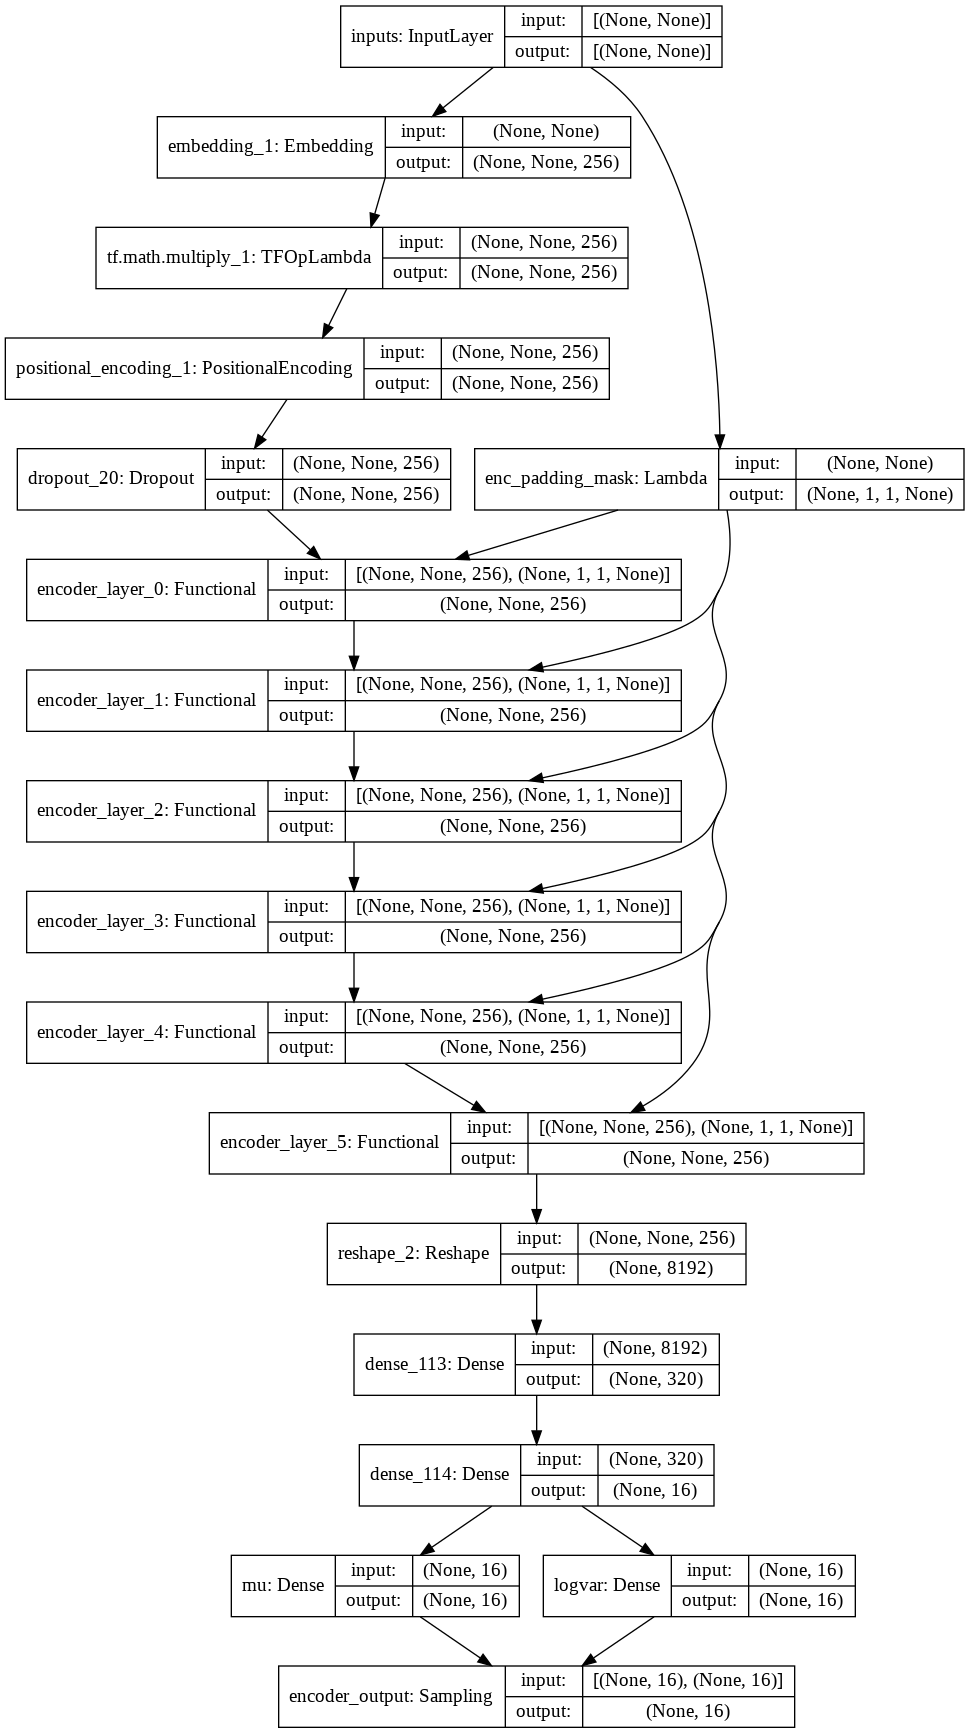

In [37]:
eo = encoder(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
    dropout=DROPOUT,
    latent_space=LATENT_SPACE)
tf.keras.utils.plot_model(eo, show_shapes=True)

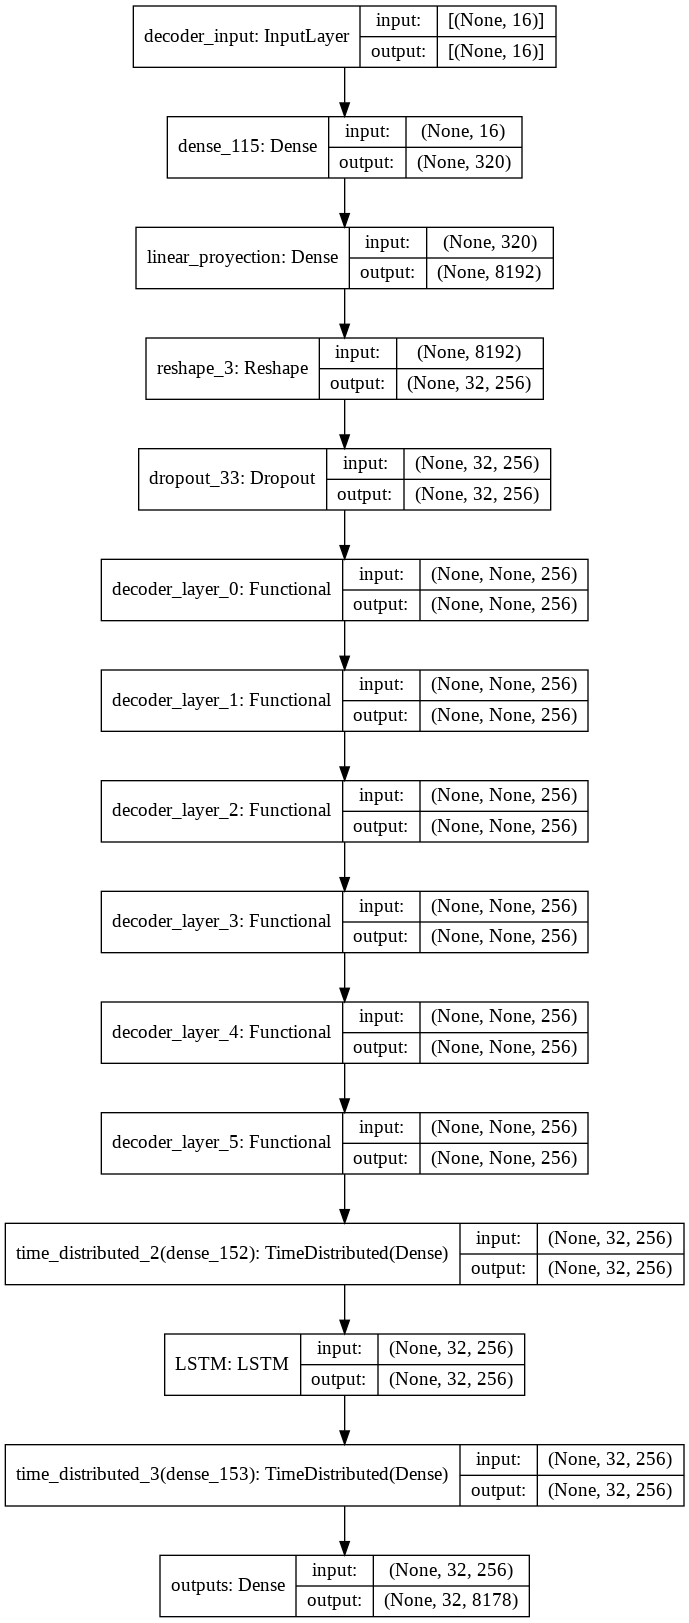

In [38]:
do = decoder(
  vocab_size=VOCAB_SIZE,
  num_layers=NUM_LAYERS,
  units=UNITS,
  d_model=D_MODEL,
  num_heads=NUM_HEADS,
  dropout=DROPOUT,
  latent_space=LATENT_SPACE)
    
tf.keras.utils.plot_model(do, show_shapes=True)
    

In [42]:
from random import randint

from nltk.translate.chrf_score import sentence_chrf

# Ejemplo de la medida del accuracy del modelo / la loss

def loss_sentence_chrf(y_true, y_pred):
  chrf_acc_mean = 0
  with suppress(Exception):
    # print(y_pred.shape)
    preds = np.argmax(y_pred, axis=-1)
    # print(preds.shape)
    chrf_acc = []
    for index, pred in enumerate(preds, start=0):
      sentence_pred = tokenizer.decode(pred)
      sentence_true = tokenizer.decode(y_true[index])
      # print(sentence_pred,"|", sentence_true)
      # print('\n')
      " ".join([str(i) for i in pred])
      sentence_pred = " ".join([str(i) for i in pred])
      sentence_true = " ".join([str(i) for i in y_true[index].numpy()])

      # print('pred:',sentence_pred)
      # print('true:',sentence_true)
      # print('\n')
      chrf_acc = sentence_chrf(sentence_pred, sentence_true, min_len=2)

      loss = (1 - chrf_acc) * 100
      # print('loss:', loss)
      # print('acc:', chrf_acc)
      # print('\n')
      chrf_acc.append(chrf_acc)
      chrf_acc_mean = tf.reduce_mean(chrf_acc_mean)
  return chrf_acc_mean


y_true = tf.constant([data_lines[randint(0,data_lines.shape[0]) - 1] for _ in range(10)])
y_pred = model.predict(y_true)

loss_sentence_chrf(y_true, y_pred)

checkpoint_call


0

In [43]:
from tensorflow.keras.callbacks import Callback, LambdaCallback


class EpochEndCallback(Callback): # Creamos una clase que herede de Callback

    def __init__(self, period=1): # Definimos los atributos que necesita la clase y los inicializamos en el constructor
        super(EpochEndCallback, self).__init__()
        self.period = period
    
    # Lo que buscamos es que cada cierta cantidad de epochs se genere un texto.
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.period == 0:
            print('Callback running', epoch)
            q_sample = data_lines[randint(0,data_lines.shape[0]) - 1]
            model.reconstruct(q_sample)
          # y_true = tf.constant([data_lines[randint(0,data_lines.shape[0]) - 1] for _ in range(100)])
          # loss_sentence_chrf(y_true, y_pred)
# Instanciamos nuestro custom callback
eec = EpochEndCallback()

### Entrenamiento

In [44]:
#defino un callback para actualizar epoch y generar variable de conteo de epochs
def count(epoch):
  K.set_value(beta, epoch)

counter = LambdaCallback(on_epoch_end=lambda epoch, log: count(epoch))

In [45]:
## nos queda armar el lr que va cambiando con el tiempo
## hay que hacer un schedule de lr:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#optimizer = tf.keras.optimizers.Adam(CustomSchedule(D_MODEL), beta_1=0.9, beta_2=0.98, 
 #                                     epsilon=1e-9)



In [ ]:
EPOCHS = 80

optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.999, 
                                     epsilon=1e-9) #for fine-tunning

model.compile(optimizer=optimizer)

history = model.fit(dataset, epochs=EPOCHS, callbacks=[eec, counter])

Epoch 1/80
ytrue: Tensor("IteratorGetNext:0", shape=(None, 32), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 32, 8178), dtype=float32)
ytrue: Tensor("IteratorGetNext:0", shape=(None, 32), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 32, 8178), dtype=float32)
2149/2149 [==============================] - 186s 81ms/step - loss: 3.3162 - reconstruction_loss: 3.3115 - kl_loss: 466.6605 - kl_weight: 1.0000e-05
Callback running 0
[5, 1, 7954, 7954, 7954, 7954, 1, 1, 1, 24, 8037, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstr:  la de     de de de del s .
Original:  donde cantan sin cesar los ruiseñores .
Epoch 2/80
2149/2149 [==============================] - 171s 80ms/step - loss: 3.0265 - reconstruction_loss: 3.0220 - kl_loss: 450.0363 - kl_weight: 1.0000e-05
Callback running 1
[5, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 7954, 79

In [ ]:
reconstruction_loss = history.history['reconstruction_loss']
loss = [np.mean(x) for x in model.history.history['loss']]
kl_loss = [np.mean(x) for x in model.history.history['kl_loss']]

epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, reconstruction_loss, label='reconstruction_loss')
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
# plt.ylim([20000, 40000])
# plt.xlim([30, 100])
plt.title('reconstruction_loss - kl_loss')
plt.legend()

plt

In [ ]:
#evolucion KL LOSS
kl_loss = [np.mean(x) for x in model.history.history['kl_loss']]

epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
plt.title('rkl_loss')
plt.legend()

plt

In [ ]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpusv3_16.HDF5', save_format='tf')
# model.load_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpusv3_16.HDF5')

## Testeamos

In [ ]:
errores = 0
for i in range(10):
  z_sampled = tf.random.normal(shape=(1,LATENT_SPACE))
  prediction = model.decode_sample(z_sampled,silent_reconstruct=True)
  if (prediction != None):
    print(prediction)
  else:
    errores += 1
print('\n')
print('\n','errores',errores)

In [ ]:
q_sample = data_lines[5]
model.reconstruct(q_sample)

In [ ]:
model.reconstruct_sentence("el devenir de los momentos")
model.reconstruct_sentence("las historias que nos contaron")
model.reconstruct_sentence("tu mirada milagrosa me salvó de su odio")
model.reconstruct_sentence("cayó como un rayo de luz que cegó al mundo") 
model.reconstruct_sentence("un hombre observaba desde el monte") 

In [ ]:
# Genera una funcion que se mueve por el espacio latente desde Oracion A hasta Oracion B
def linear_interpolate(sample1, sample2, cant_sentences = 5 ):
  print('desde:', tokenizer.decode(sample1),'\n')

  _,_,result1 = model.encoder(sample1.reshape(1,MAX_LENGTH,1))
  _,_,result2 = model.encoder(sample2.reshape(1,MAX_LENGTH,1))

  #Resto los valores del espacio latente y los divido por la cantidad de oracione que quiero generar
  vector = ((result1[0] - result2[0]).numpy()) / cant_sentences 

  for i in range(cant_sentences):
    result_int = result1 - vector * i
    print('step', str(i + 1) + ':', model.decode_sample(result_int, silent_reconstruct=True))

  print('')
  print('hasta:', tokenizer.decode(q_sample2))


In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B sampleadas del entrenamiento
q_sample1 = data_lines[randint(0,data_lines.shape[0]) - 1]
q_sample2 = data_lines[randint(0,data_lines.shape[0]) - 1]

linear_interpolate(q_sample1, q_sample2,6)


# Analisis Visual del espacio latente

In [ ]:
def encode_sentence(sentence):
    sentence = [sentence]
    sentence = tokenize_and_filter(sentence)
    sentence = sentence.reshape(MAX_LENGTH)
    return sentence

In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("un hombre observaba desde el monte")
q_sample2 = encode_sentence("deberas dejar cerrada aquella puerta")

linear_interpolate(q_sample1, q_sample2,5)

In [ ]:
model.reconstruct_sentence("los inicia")
model.reconstruct_sentence("se encontró transformado en un insecto.")

In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("Al despertarse una mañana, después de un sueño intranquilo")
q_sample2 = encode_sentence("se encontró en su cama transformado en un monstruoso insecto")

linear_interpolate(q_sample1, q_sample2,5)

In [ ]:
z_mean, _, _ = model.encoder.predict(dataset)

In [ ]:
# Analisis Visual del espacio latente
def plot_label_clusters(vae, z_mean, labels=None, z_fixed=0):
  # display a 2D plot of the digit classes in the latent space
  
  fig, axes = plt.subplots(4, 4, figsize=(16,16))
  fig.subplots_adjust(hspace=0.2)
  z = 0
  for x in range(4):
    for y in range(4): 
      axes[x, y].scatter(z_mean[:, z_fixed], z_mean[:, z])
      axes[x, y].set_xlabel("z["+ str(z_fixed) +"] | z["+ str(z) +"]") 
      # axes[x, y].ylabel("z["+ str(i) +"]")
      z += 1



In [ ]:
plot_label_clusters(model, z_mean, None, 0)

In [ ]:
plot_label_clusters(model, z_mean, None, 5)

Visualización de como cambia el factor de loss en kl para los parametros y cantidad de epochs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#TODO ver si deberian haber epochs suficientes para completar "forma" de la funcion
x = np.linspace(0,EPOCHS,10)

y = 1/(1+tf.exp(-A*x+10))

# setting the axes at the centre
fig = plt.figure()
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_label("EPOCHS")

# plot the function
plt.plot(x,y, 'r')

# show the plot
plt.show()
